<a href="https://colab.research.google.com/github/GiovaniValdrighi/school_eval_ethical/blob/main/notebooks/fairness_mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install fairgbm scikit-lego aif360 fairlearn

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from aif360.algorithms.preprocessing import Reweighing
from fairlearn.postprocessing import ThresholdOptimizer
from fairgbm import FairGBMClassifier
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import GridSearchCV
from sklego.linear_model import DemographicParityClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, brier_score_loss
from time import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
PATH_ROOT = "/content/drive/MyDrive/courses/ai_ethics/school_eval/"
TRAIN_MODELS = False # use False for not training models that have long computational cost

In [9]:
studied_model = pkl.load(open(PATH_ROOT + "results/lr_causal_feature_selection_grid.pkl", "rb"))
X_train = pd.read_csv(PATH_ROOT + "data/X_train_clean.csv")
X_test = pd.read_csv(PATH_ROOT + "data/X_test_clean.csv")
Y_train = pd.read_csv(PATH_ROOT + "data/Y_train_clean.csv")
Y_test = pd.read_csv(PATH_ROOT + "data/Y_test_clean.csv")

In [6]:
causal_features = ['TX_RESP_Q075',
  'TX_RESP_Q018',
  'TX_RESP_Q203',
  'TX_RESP_Q162',
  'TX_RESP_Q046',
  'TX_RESP_Q236',
  'TX_RESP_Q049',
  'TX_RESP_Q131',
  'TX_RESP_Q163',
  'TX_RESP_Q166',
  'TX_RESP_Q167',
  'TX_RESP_Q001',
  'TX_RESP_Q133',
  'TX_RESP_Q115',
  'NU_PRESENTES_9EF',
  'TX_RESP_Q112',
  'TX_RESP_Q078',
  'TX_RESP_Q181',
  'TX_RESP_Q165',
  'TX_RESP_Q200',
  'NU_MATRICULADOS_CENSO_9EF',
  'TX_RESP_Q134',
  'TX_RESP_Q160',
  'TX_RESP_Q225',
  'TX_RESP_Q101',
  'TX_RESP_Q082',
  'TX_RESP_Q091',
  'TX_RESP_Q108',
  'NIVEL_SOCIO_ECONOMICO',
  'TX_RESP_Q201',
  'TX_RESP_Q035',
  'TX_RESP_Q016',
  'ID_REGIAO',
  'TX_RESP_Q250',
  'TX_RESP_Q155',
  'TX_RESP_Q056',
  'TX_RESP_Q137',
  'TX_RESP_Q153',
  'TX_RESP_Q151',
  'TX_RESP_Q038',
  'TX_RESP_Q164',
  'TX_RESP_Q210',
  'TX_RESP_Q243',
  'TX_RESP_Q118',
  'PC_FORMACAO_DOCENTE_FINAL',
  'TX_RESP_Q053',
  'TX_RESP_Q158',
  'ID_UF',
  'TX_RESP_Q117',
  'TX_RESP_Q063']

In [7]:
X_train_causal = X_train[causal_features]
X_test_causal = X_test[causal_features]

In [11]:
Y_pred_train = studied_model.predict(X_train_causal)
Y_pred_test = studied_model.predict(X_test_causal)

In [ ]:
features_info_dict ={
  'TX_RESP_Q075': 'Violence led class cancellations.',
  'TX_RESP_Q018': 'Weekly director spent in snack time hours (0-30).',
  'TX_RESP_Q203': 'Promote peer support to reduce repetition.',
  'TX_RESP_Q162': 'Student involvement in planning?',
  'TX_RESP_Q046': 'Received Department of Ed. support?',
  'TX_RESP_Q236': 'Need for Libras teacher?',
  'TX_RESP_Q049': 'Agree on easy teacher substitutions?',
  'TX_RESP_Q131': 'Class Council meetings this year?',
  'TX_RESP_Q163': 'Setting learning goals?',
  'TX_RESP_Q166': 'All applicants enrolled this year?',
  'TX_RESP_Q167': 'Criteria for new student enrollment: Drawing?',
  'TX_RESP_Q001': 'Your color or race?',
  'TX_RESP_Q133': 'PTA meetings this year?',
  'TX_RESP_Q115': 'School buys personal hygiene materials?',
  'TX_RESP_Q112': 'School buys pedagogical resources?',
  'TX_RESP_Q078': "Childrens shower-equipped bathroom?",
  'TX_RESP_Q181': 'Criteria for class formation: Performance grouping.',
  'TX_RESP_Q165': 'Goals for external indicators?',
  'TX_RESP_Q200': 'Actions to reduce school drop-out: Home visits.',
  'TX_RESP_Q134': 'Existence of Student Union?',
  'TX_RESP_Q160': 'Teacher participation in planning?',
  'TX_RESP_Q225': 'School offered large-scale assessment training?',
  'TX_RESP_Q101': 'Equipment in external recreation areas: Bench?',
  'TX_RESP_Q082': 'External area items: Covered area?',
  'TX_RESP_Q091': 'External area soil/flooring: Ceramic?',
  'TX_RESP_Q108': 'External identification of school building?',
  'TX_RESP_Q201': 'Actions to reduce drop-out: Informing Guardianship Council.',
  'TX_RESP_Q035': 'Educational stages served: Early Ed. and Preschool (4-5 yrs).',
  'TX_RESP_Q016': 'Hours for individual teacher assistance (0-30).',
  'TX_RESP_Q250': 'Training areas: High abilities/giftedness?',
  'TX_RESP_Q155': 'Sinks for hand hygiene near feeding area?',
  'TX_RESP_Q056': 'All students received textbooks?',
  'TX_RESP_Q137': 'School follows religious orientation?',
  'TX_RESP_Q153': 'Everyone eats while sitting?',
  'TX_RESP_Q151': 'Food quality is good?',
  'TX_RESP_Q038': 'Educational stages served: High School.',
  'TX_RESP_Q164': 'Considers external assessment results?'
}

## Fairness evaluation

In [10]:
sensitive_features = {
    "ID_REGIAO" : "region",
    "NIVEL_SOCIO_ECONOMICO" : "socioeconomic_index"
}

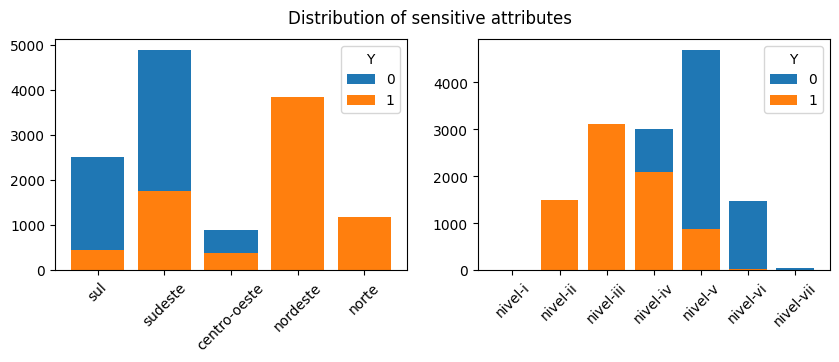

In [35]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))
base = np.zeros(5)
for y in [0, 1]:
  bars = []
  for col in ["sul", "sudeste", "centro-oeste", "nordeste", "norte"]:
    y_ = Y_train[X_train["ID_REGIAO"] == col].values
    bars.append((y_ == y).sum())
  axs[0].bar(np.arange(len(bars)), bars, label = str(y))
axs[0].legend(title = "Y")
axs[0].set_xticks(np.arange(len(bars)))
axs[0].set_xticklabels(["sul", "sudeste", "centro-oeste", "nordeste", "norte"], rotation = 45)


base = np.zeros(7)
for y in [0, 1]:
  bars = []
  for col in ['nivel-i', 'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi',  'nivel-vii']:
    y_ = Y_train[X_train["NIVEL_SOCIO_ECONOMICO"] == col].values
    bars.append((y_ == y).sum())
  axs[1].bar(np.arange(len(bars)), bars, label = str(y))
axs[1].legend(title = "Y")
axs[1].set_xticks(np.arange(len(bars)))
axs[1].set_xticklabels(['nivel-i', 'nivel-ii', 'nivel-iii', 'nivel-iv', 'nivel-v', 'nivel-vi',  'nivel-vii'], rotation = 45)
plt.suptitle("Distribution of sensitive attributes")
plt.show()


In [37]:
regiao_attr_train = X_train.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values
regiao_attr_test = X_test.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values

socioeconomic_attr_train = X_train.NIVEL_SOCIO_ECONOMICO.apply(lambda x : 1 if x in ["nivel-i", "nivel-ii", "nivel-iii", "nivel-iv"] else 0).values
socioeconomic_attr_test = X_test.NIVEL_SOCIO_ECONOMICO.apply(lambda x : 1 if x in ["nivel-i", "nivel-ii", "nivel-iii", "nivel-iv"] else 0).values

In [36]:
def demographic_parity(Y, A):
  return np.mean(Y[A == 1]) - np.mean(Y[A == 0])

In [43]:
print("Measures of dataset")
print(f"Region unfairness (DP) {demographic_parity(Y_train.values, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (DP) {demographic_parity(Y_train.values, socioeconomic_attr_train):.3f}")

Measures of dataset
Region unfairness (DP) 0.366
Socioeconomic level unfairness (DP) 0.427


In [53]:
def equal_opportunity(Y_target, Y_pred, A):
  tpr_1 = np.mean(Y_pred[(Y_target == 1) & (A == 1)])
  tpr_0 = np.mean(Y_pred[(Y_target == 1) & (A == 0)])
  return tpr_1 - tpr_0

In [54]:
print("Measures of model")
print(f"Region unfairness (DP) {demographic_parity(Y_pred_train, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (DP) {demographic_parity(Y_pred_train, socioeconomic_attr_train):.3f}")
print(f"Region unfairness (EO) {equal_opportunity(Y_train.values.flat, Y_pred_train, regiao_attr_train):.3f}")
print(f"Socioeconomic level unfairness (EO) {equal_opportunity(Y_train.values.flat, Y_pred_train, socioeconomic_attr_train):.3f}")

Measures of model
Region unfairness (DP) 0.546
Socioeconomic level unfairness (DP) 0.564
Region unfairness (EO) 0.520
Socioeconomic level unfairness (EO) 0.731


## Fairness mitigation

In [60]:
num_features = ['PC_FORMACAO_DOCENTE_FINAL',
 'NU_MATRICULADOS_CENSO_9EF',
 'NU_PRESENTES_9EF',
 'TX_RESP_Q016',
 'TX_RESP_Q018']

binary_features = ['TX_RESP_Q035',
 'TX_RESP_Q038',
 'TX_RESP_Q063',
 'TX_RESP_Q078',
 'TX_RESP_Q082',
 'TX_RESP_Q091',
 'TX_RESP_Q101',
 'TX_RESP_Q112',
 'TX_RESP_Q115',
 'TX_RESP_Q117',
 'TX_RESP_Q131',
 'TX_RESP_Q133',
 'TX_RESP_Q137',
 'TX_RESP_Q158',
 'TX_RESP_Q166',
 'TX_RESP_Q167',
 'TX_RESP_Q181',
 'TX_RESP_Q210',
 'TX_RESP_Q225',
 'TX_RESP_Q236',
 'TX_RESP_Q243',
 'TX_RESP_Q250']

cat_features = ['ID_REGIAO',
 'ID_UF',
 'NIVEL_SOCIO_ECONOMICO',
 'TX_RESP_Q001',
 'TX_RESP_Q046',
 'TX_RESP_Q049',
 'TX_RESP_Q053',
 'TX_RESP_Q056',
 'TX_RESP_Q075',
 'TX_RESP_Q108',
 'TX_RESP_Q118',
 'TX_RESP_Q134',
 'TX_RESP_Q151',
 'TX_RESP_Q153',
 'TX_RESP_Q155',
 'TX_RESP_Q160',
 'TX_RESP_Q162',
 'TX_RESP_Q163',
 'TX_RESP_Q164',
 'TX_RESP_Q165',
 'TX_RESP_Q200',
 'TX_RESP_Q201',
 'TX_RESP_Q203']

In [98]:
params_space = {}
params_space["FairGBM"] = {
  "classifier__max_depth" : [4, 6, 8],
  #"classifier__colsample_bytree" : [0.5, 0.75, 1],
  #"classifier__n_estimators" : [10, 15, 20, 50],
  #"classifier__lambda_l2" : [0.1, 1, 10, 100],
  #"classifier__verbose" : [-1],
}
params_space["DPClassifier"] = {
    "classifier__estimator__covariance_threshold" :  [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__estimator__C" :  [0.01, 0.1, 1, 10, 100],
    "classifier__estimator__max_iter" : [1000]
}
params_space["lr_rw"] = {
      "classifier__C" :  [0.01, 0.1, 1, 10, 100],
      "classifier__max_iter" : [1000]
}

In [74]:
def get_pipeline(model = None):
  pipeline = [(
    "preprocess",
    ColumnTransformer([
        ["scaling", StandardScaler(), num_features],
        ["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore"), cat_features]
      ], remainder = "passthrough", verbose_feature_names_out=False)
  )]
  pipeline[0][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model)]
  return Pipeline(pipeline)

### Pre-processing

In [101]:
preprocess = get_pipeline()
preprocess.fit(X_train_causal)
df_rw = preprocess.transform(X_train_causal)
df_rw["SUPPORT"] = Y_train.values
df_rw["socioeconomic_attr"] = socioeconomic_attr_train
x_train_aif = BinaryLabelDataset(
    df = df_rw,
    label_names = ["SUPPORT"],
    protected_attribute_names = ["socioeconomic_attr"]
)
rw = Reweighing(
    unprivileged_groups = [{"socioeconomic_attr": 1}],
    privileged_groups = [{"socioeconomic_attr": 0}],
)
rw.fit(x_train_aif)
rw_weights = rw.transform(x_train_aif).instance_weights
name = "lr_rw"
start = time()
m = get_pipeline(LogisticRegression())
grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
grid.fit(X_train_causal, Y_train.values.ravel(), classifier__sample_weight = rw_weights)
pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
end = time()
print(f"Finished {name} in {end - start}")

Finished lr_rw in 28.005990266799927


### In-processing

In [78]:
X_train_causal_ = X_train_causal.copy()
X_train_causal_["socioeconomic_attr"] = socioeconomic_attr_train

In [ ]:
name = "DPClassifier"
start = time()
m = get_pipeline(DemographicParityClassifier(
    covariance_threshold = 0.1,
    sensitive_cols = "socioeconomic_attr",
    train_sensitive_cols = False
))
grid = GridSearchCV(m, params_space[name], scoring = "recall", n_jobs = -1)
grid.fit(X_train_causal_, Y_train.values.ravel())
pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
end = time()
print(f"Finished {name} in {end - start}")


In [72]:
name = "FairGBM"
start = time()
m = get_pipeline(FairGBMClassifier)
grid = GridSearchCV(m(), params_space["FairGBM"], scoring = "recall", n_jobs = -1)
grid.fit(X_train_causal, Y_train.values.ravel(), classifier__constraint_group = socioeconomic_attr_train)
pkl.dump(grid, open(PATH_ROOT + "results/" + name + "_grid.pkl", "wb"))
end = time()
print(f"Finished {name} in {end - start}")


### Post-processing

In [ ]:
name = "threshold_opt"
m = ThresholdOptimizer(
  estimator=studied_model,
  constraints="demographic_parity",
  objective="accuracy_score",
  prefit=True,
  predict_method="predict_proba",
)
m.fit(X_train_causal, Y_train, sensitive_features=socioeconomic_attr_train)